# Training a ConvNet PyTorch

In this notebook, you'll learn how to use the powerful PyTorch framework to specify a conv net architecture and train it on the CIFAR-10 dataset.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt

import timeit

## What's this PyTorch business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, PyTorch (or TensorFlow, if you switch over to that notebook). 

Why?

* Our code will now run on GPUs! Much faster training. When using a framework like PyTorch or TensorFlow you can harness the power of the GPU for your own custom neural network architectures without having to write CUDA code directly (which is beyond the scope of this class).
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn PyTorch?

If you've used Torch before, but are new to PyTorch, this tutorial might be of use: http://pytorch.org/tutorials/beginner/former_torchies_tutorial.html

Otherwise, this notebook will walk you through much of what you need to do to train models in Torch. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets

We load the CIFAR-10 dataset. This might take a couple minutes the first time you do it, but the files should stay cached after that.

In [2]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 49000
NUM_VAL = 1000

train_transform = T.Compose([
    T.RandomResizedCrop(28),
    T.RandomHorizontalFlip(),
    T.Resize(32),
    T.ToTensor(),
    T.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                std = [ 0.229, 0.224, 0.225 ]),
])


test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                std = [ 0.229, 0.224, 0.225 ]),
])

cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=train_transform)
loader_train = DataLoader(cifar10_train, batch_size=98, sampler=ChunkSampler(NUM_TRAIN, 0))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=test_transform)
loader_val = DataLoader(cifar10_val, batch_size=100, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True,
                          transform=test_transform)
loader_test = DataLoader(cifar10_test, batch_size=100)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


For now, we're going to use a CPU-friendly datatype. Later, we'll switch to a datatype that will move all our computations to the GPU and measure the speedup.

In [3]:
dtype = torch.FloatTensor # the CPU datatype

# Constant to control how frequently we print train loss
print_every = 100

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

## Example Model

### Some assorted tidbits

Let's start by looking at a simple model. First, note that PyTorch operates on Tensors, which are n-dimensional arrays functionally analogous to numpy's ndarrays, with the additional feature that they can be used for computations on GPUs.

We'll provide you with a Flatten function, which we explain here. Remember that our image data (and more relevantly, our intermediate feature maps) are initially N x C x H x W, where:
* N is the number of datapoints
* C is the number of channels
* H is the height of the intermediate feature map in pixels
* W is the height of the intermediate feature map in pixels

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we input  data into fully connected affine layers, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "Flatten" operation to collapse the C x H x W values per representation into a single long vector. The Flatten function below first reads in the N, C, H, and W values from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be C x H x W, but we don't need to specify that explicitly). 

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in PyTorch -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up.  nn.Sequential is a container which applies each layer
one after the other.

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Cross-Entropy loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.


In [5]:
# Here's where we define the architecture of the model... 
simple_model = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                Flatten(), # see above for explanation
                nn.Linear(5408, 10), # affine layer
              )

# Set the type of all data in this model to be FloatTensor 
simple_model.type(dtype)

loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(simple_model.parameters(), lr=1e-2) # lr sets the learning rate of the optimizer

PyTorch supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). One note: what we call in the class "spatial batch norm" is called "BatchNorm2D" in PyTorch.

* Layers: http://pytorch.org/docs/nn.html
* Activations: http://pytorch.org/docs/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/optim.html#algorithms

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the PyTorch documentation and configuring your own model. 

Using the code provided above as guidance, and using the following PyTorch documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs

And finally, set up a **cross-entropy** loss function and the **RMSprop** learning rule.

In [6]:
fixed_model_base = nn.Sequential( # You fill this in!
                    nn.Conv2d(3, 32, kernel_size=7, stride=1),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(32, affine=False),
                    nn.MaxPool2d(2, stride=2),
                    Flatten(),
                    nn.Linear(5408, 1024),
                    nn.ReLU(inplace=True),
                    nn.Linear(1024, 10),
            )

fixed_model = fixed_model_base.type(dtype)

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [7]:
## Now we're going to feed a random batch into the model you defined and make sure the output is the right size
x = torch.randn(64, 3, 32, 32).type(dtype)
x_var = Variable(x.type(dtype)) # Construct a PyTorch Variable out of your input data
ans = fixed_model(x_var)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([64, 10]))       

True

### GPU!

Now, we're going to switch the dtype of the model and our data to the GPU-friendly tensors, and see what happens... everything is the same, except we are casting our model and input tensors as this new dtype instead of the old one.

If this returns false, or otherwise fails in a not-graceful way (i.e., with some error message), you may not have an NVIDIA GPU available on your machine. If you're running locally, we recommend you switch to Google Cloud and follow the instructions to set up a GPU there. If you're already on Google Cloud, something is wrong -- make sure you followed the instructions on how to request and use a GPU on your instance. If you did, post on Piazza or come to Office Hours so we can help you debug.

In [8]:
# Verify that CUDA is properly configured and you have a GPU available

torch.cuda.is_available()

True

In [9]:
import copy
gpu_dtype = torch.cuda.FloatTensor

fixed_model_gpu = copy.deepcopy(fixed_model_base).type(gpu_dtype)

x_gpu = torch.randn(64, 3, 32, 32).type(gpu_dtype)
x_var_gpu = Variable(x.type(gpu_dtype)) # Construct a PyTorch Variable out of your input data
ans = fixed_model_gpu(x_var_gpu)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([64, 10]))

True

Run the following cell to evaluate the performance of the forward pass running on the CPU:

In [10]:
%%timeit 
ans = fixed_model(x_var)

74.8 ms ± 6.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


... and now the GPU:

In [11]:
%%timeit 
torch.cuda.synchronize() # Make sure there are no pending GPU computations
ans = fixed_model_gpu(x_var_gpu)        # Feed it through the model! 
torch.cuda.synchronize() # Make sure there are no pending GPU computations

1.27 ms ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use the GPU datatype for your model and your tensors: as a reminder that is *torch.cuda.FloatTensor* (in our notebook here as *gpu_dtype*)

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the simple_model we provided above).

Make sure you understand how each PyTorch function used below corresponds to what you implemented in your custom neural network implementation.

Note that because we are not resetting the weights anywhere below, if you run the cell multiple times, you are effectively training multiple epochs (so your performance should improve).

First, set up an RMSprop optimizer (using a 1e-3 learning rate) and a cross-entropy loss function:

In [12]:
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.RMSprop(fixed_model_gpu.parameters(), lr=1e-3)
pass


In [13]:
# This sets the model in "training" mode. This is relevant for some layers that may have different behavior
# in training mode vs testing mode, such as Dropout and BatchNorm. 
fixed_model_gpu.train()

# Load one batch at a time.
for t, (x, y) in enumerate(loader_train):
    x_var = Variable(x.type(gpu_dtype))
    y_var = Variable(y.type(gpu_dtype).long())

    # This is the forward pass: predict the scores for each class, for each x in the batch.
    scores = fixed_model_gpu(x_var)
    
    # Use the correct y values and the predicted y values to compute the loss.
    loss = loss_fn(scores, y_var)
    
    if (t + 1) % print_every == 0:
        print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

    # Zero out all of the gradients for the variables which the optimizer will update.
    optimizer.zero_grad()
    
    # This is the backwards pass: compute the gradient of the loss with respect to each 
    # parameter of the model.
    loss.backward()
    
    # Actually update the parameters of the model using the gradients computed by the backwards pass.
    optimizer.step()

t = 100, loss = 2.3361
t = 200, loss = 2.1028
t = 300, loss = 1.8585
t = 400, loss = 1.8033
t = 500, loss = 1.8755


Now you've seen how the training process works in PyTorch. To save you writing boilerplate code, we're providing the following helper functions to help you train for multiple epochs and check the accuracy of your model:

In [14]:
def train(model, loss_fn, optimizer, num_epochs = 1, scheduler=None, plot_losses=False):
    total_losses = []
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        if scheduler:
            scheduler.step()
        model.train()
        losses = []
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            losses.append(loss*loader_train.batch_size)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, np.sum(losses[-print_every:]) / loader_train.batch_size / print_every))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_losses.append(np.sum(losses)/loader_train.sampler.num_samples)
    if plot_losses and len(total_losses) > 1:
        plt.grid(True)
        plt.title('Result')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim(0,3)
        plt.plot(total_losses, label='loss')
        plt.show()

def check_accuracy(model, loader):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

### Check the accuracy of the model.

Let's see the train and check_accuracy code in action -- feel free to use these methods when evaluating the models you develop below.

You should get a training loss of around 1.2-1.4, and a validation accuracy of around 50-60%. As mentioned above, if you re-run the cells, you'll be training more epochs, so your performance will improve past these numbers.

But don't worry about getting these numbers better -- this was just practice before you tackle designing your own model.

In [15]:
torch.cuda.random.manual_seed(12345)
fixed_model_gpu.apply(reset)
train(fixed_model_gpu, loss_fn, optimizer, num_epochs=1)
check_accuracy(fixed_model_gpu, loader_val)

Starting epoch 1 / 1
t = 100, loss = 4.1495
t = 200, loss = 2.0662
t = 300, loss = 1.8854
t = 400, loss = 1.8565
t = 500, loss = 1.8454
Checking accuracy on validation set
Got 415 / 1000 correct (41.50)


### Don't forget the validation set!

And note that you can use the check_accuracy function to evaluate on either the test set or the validation set, by passing either **loader_test** or **loader_val** as the second argument to check_accuracy. You should not touch the test set until you have finished your architecture and hyperparameter tuning, and only run the test set once at the end to report a final value. 

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves **>=70%** accuracy on the CIFAR-10 **validation** set. You can use the check_accuracy and train functions from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at least 70% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. 

Have fun and happy training!

Starting epoch 1 / 500
t = 100, loss = 2.0539
t = 200, loss = 1.9163
t = 300, loss = 1.8117
t = 400, loss = 1.7740
t = 500, loss = 1.7434
Starting epoch 2 / 500
t = 100, loss = 1.6834
t = 200, loss = 1.6614
t = 300, loss = 1.5933
t = 400, loss = 1.5826
t = 500, loss = 1.5310
Starting epoch 3 / 500
t = 100, loss = 1.4884
t = 200, loss = 1.4633
t = 300, loss = 1.4165
t = 400, loss = 1.4221
t = 500, loss = 1.3926
Starting epoch 4 / 500
t = 100, loss = 1.3717
t = 200, loss = 1.3497
t = 300, loss = 1.3200
t = 400, loss = 1.3251
t = 500, loss = 1.3119
Starting epoch 5 / 500
t = 100, loss = 1.2786
t = 200, loss = 1.2829
t = 300, loss = 1.2667
t = 400, loss = 1.2543
t = 500, loss = 1.2533
Starting epoch 6 / 500
t = 100, loss = 1.2238
t = 200, loss = 1.2473
t = 300, loss = 1.2066
t = 400, loss = 1.2097
t = 500, loss = 1.2016
Starting epoch 7 / 500
t = 100, loss = 1.1844
t = 200, loss = 1.1999
t = 300, loss = 1.1463
t = 400, loss = 1.1814
t = 500, loss = 1.1494
Starting epoch 8 / 500
t = 100, lo

t = 100, loss = 0.9295
t = 200, loss = 0.9685
t = 300, loss = 0.9173
t = 400, loss = 0.9669
t = 500, loss = 0.9626
Starting epoch 61 / 500
t = 100, loss = 0.9447
t = 200, loss = 0.9572
t = 300, loss = 0.9175
t = 400, loss = 0.9575
t = 500, loss = 0.9364
Starting epoch 62 / 500
t = 100, loss = 0.9541
t = 200, loss = 0.9569
t = 300, loss = 0.9388
t = 400, loss = 0.9589
t = 500, loss = 0.9360
Starting epoch 63 / 500
t = 100, loss = 0.9465
t = 200, loss = 0.9550
t = 300, loss = 0.9269
t = 400, loss = 0.9463
t = 500, loss = 0.9613
Starting epoch 64 / 500
t = 100, loss = 0.9345
t = 200, loss = 0.9368
t = 300, loss = 0.9281
t = 400, loss = 0.9479
t = 500, loss = 0.9551
Starting epoch 65 / 500
t = 100, loss = 0.9388
t = 200, loss = 0.9527
t = 300, loss = 0.9431
t = 400, loss = 0.9559
t = 500, loss = 0.9284
Starting epoch 66 / 500
t = 100, loss = 0.9608
t = 200, loss = 0.9313
t = 300, loss = 0.9417
t = 400, loss = 0.9700
t = 500, loss = 0.9438
Starting epoch 67 / 500
t = 100, loss = 0.9218
t = 

t = 100, loss = 0.5918
t = 200, loss = 0.5867
t = 300, loss = 0.5916
t = 400, loss = 0.5805
t = 500, loss = 0.5873
Starting epoch 120 / 500
t = 100, loss = 0.5837
t = 200, loss = 0.6044
t = 300, loss = 0.5912
t = 400, loss = 0.5997
t = 500, loss = 0.5822
Starting epoch 121 / 500
t = 100, loss = 0.5942
t = 200, loss = 0.5980
t = 300, loss = 0.5806
t = 400, loss = 0.5976
t = 500, loss = 0.5813
Starting epoch 122 / 500
t = 100, loss = 0.5721
t = 200, loss = 0.5853
t = 300, loss = 0.5829
t = 400, loss = 0.6073
t = 500, loss = 0.5866
Starting epoch 123 / 500
t = 100, loss = 0.5826
t = 200, loss = 0.5893
t = 300, loss = 0.5800
t = 400, loss = 0.6004
t = 500, loss = 0.5947
Starting epoch 124 / 500
t = 100, loss = 0.5711
t = 200, loss = 0.6088
t = 300, loss = 0.5921
t = 400, loss = 0.5920
t = 500, loss = 0.5994
Starting epoch 125 / 500
t = 100, loss = 0.5796
t = 200, loss = 0.5998
t = 300, loss = 0.5889
t = 400, loss = 0.5813
t = 500, loss = 0.5834
Starting epoch 126 / 500
t = 100, loss = 0.57

t = 500, loss = 0.5634
Starting epoch 178 / 500
t = 100, loss = 0.5542
t = 200, loss = 0.5530
t = 300, loss = 0.5532
t = 400, loss = 0.5589
t = 500, loss = 0.5634
Starting epoch 179 / 500
t = 100, loss = 0.5584
t = 200, loss = 0.5565
t = 300, loss = 0.5452
t = 400, loss = 0.5654
t = 500, loss = 0.5622
Starting epoch 180 / 500
t = 100, loss = 0.5450
t = 200, loss = 0.5711
t = 300, loss = 0.5571
t = 400, loss = 0.5824
t = 500, loss = 0.5607
Starting epoch 181 / 500
t = 100, loss = 0.5506
t = 200, loss = 0.5729
t = 300, loss = 0.5538
t = 400, loss = 0.5652
t = 500, loss = 0.5657
Starting epoch 182 / 500
t = 100, loss = 0.5459
t = 200, loss = 0.5750
t = 300, loss = 0.5472
t = 400, loss = 0.5617
t = 500, loss = 0.5524
Starting epoch 183 / 500
t = 100, loss = 0.5410
t = 200, loss = 0.5640
t = 300, loss = 0.5534
t = 400, loss = 0.5767
t = 500, loss = 0.5641
Starting epoch 184 / 500
t = 100, loss = 0.5736
t = 200, loss = 0.5567
t = 300, loss = 0.5496
t = 400, loss = 0.5557
t = 500, loss = 0.55

t = 300, loss = 0.3781
t = 400, loss = 0.3894
t = 500, loss = 0.3611
Starting epoch 237 / 500
t = 100, loss = 0.3848
t = 200, loss = 0.3985
t = 300, loss = 0.3725
t = 400, loss = 0.3839
t = 500, loss = 0.3761
Starting epoch 238 / 500
t = 100, loss = 0.3821
t = 200, loss = 0.3828
t = 300, loss = 0.3785
t = 400, loss = 0.3813
t = 500, loss = 0.3551
Starting epoch 239 / 500
t = 100, loss = 0.3799
t = 200, loss = 0.3822
t = 300, loss = 0.3671
t = 400, loss = 0.3813
t = 500, loss = 0.3722
Starting epoch 240 / 500
t = 100, loss = 0.3865
t = 200, loss = 0.3760
t = 300, loss = 0.3687
t = 400, loss = 0.3794
t = 500, loss = 0.3844
Starting epoch 241 / 500
t = 100, loss = 0.3880
t = 200, loss = 0.3846
t = 300, loss = 0.3796
t = 400, loss = 0.3659
t = 500, loss = 0.3765
Starting epoch 242 / 500
t = 100, loss = 0.3859
t = 200, loss = 0.3813
t = 300, loss = 0.3569
t = 400, loss = 0.3648
t = 500, loss = 0.3826
Starting epoch 243 / 500
t = 100, loss = 0.3787
t = 200, loss = 0.3789
t = 300, loss = 0.36

t = 100, loss = 0.3660
t = 200, loss = 0.3620
t = 300, loss = 0.3442
t = 400, loss = 0.3595
t = 500, loss = 0.3521
Starting epoch 296 / 500
t = 100, loss = 0.3507
t = 200, loss = 0.3482
t = 300, loss = 0.3523
t = 400, loss = 0.3629
t = 500, loss = 0.3484
Starting epoch 297 / 500
t = 100, loss = 0.3616
t = 200, loss = 0.3520
t = 300, loss = 0.3456
t = 400, loss = 0.3544
t = 500, loss = 0.3473
Starting epoch 298 / 500
t = 100, loss = 0.3535
t = 200, loss = 0.3489
t = 300, loss = 0.3436
t = 400, loss = 0.3435
t = 500, loss = 0.3544
Starting epoch 299 / 500
t = 100, loss = 0.3587
t = 200, loss = 0.3531
t = 300, loss = 0.3509
t = 400, loss = 0.3504
t = 500, loss = 0.3501
Starting epoch 300 / 500
t = 100, loss = 0.3474
t = 200, loss = 0.3552
t = 300, loss = 0.3508
t = 400, loss = 0.3428
t = 500, loss = 0.3560
Starting epoch 301 / 500
t = 100, loss = 0.3528
t = 200, loss = 0.3610
t = 300, loss = 0.3316
t = 400, loss = 0.3299
t = 500, loss = 0.3370
Starting epoch 302 / 500
t = 100, loss = 0.34

t = 500, loss = 0.3119
Starting epoch 354 / 500
t = 100, loss = 0.3174
t = 200, loss = 0.3312
t = 300, loss = 0.3112
t = 400, loss = 0.3214
t = 500, loss = 0.3169
Starting epoch 355 / 500
t = 100, loss = 0.3238
t = 200, loss = 0.3209
t = 300, loss = 0.3037
t = 400, loss = 0.3272
t = 500, loss = 0.3255
Starting epoch 356 / 500
t = 100, loss = 0.3163
t = 200, loss = 0.3250
t = 300, loss = 0.3158
t = 400, loss = 0.3227
t = 500, loss = 0.3219
Starting epoch 357 / 500
t = 100, loss = 0.3233
t = 200, loss = 0.3219
t = 300, loss = 0.3150
t = 400, loss = 0.3069
t = 500, loss = 0.3036
Starting epoch 358 / 500
t = 100, loss = 0.3212
t = 200, loss = 0.3253
t = 300, loss = 0.3108
t = 400, loss = 0.3286
t = 500, loss = 0.3235
Starting epoch 359 / 500
t = 100, loss = 0.3163
t = 200, loss = 0.3283
t = 300, loss = 0.3290
t = 400, loss = 0.3199
t = 500, loss = 0.3122
Starting epoch 360 / 500
t = 100, loss = 0.3112
t = 200, loss = 0.3235
t = 300, loss = 0.3200
t = 400, loss = 0.3184
t = 500, loss = 0.31

t = 300, loss = 0.3051
t = 400, loss = 0.3191
t = 500, loss = 0.3132
Starting epoch 413 / 500
t = 100, loss = 0.3108
t = 200, loss = 0.3159
t = 300, loss = 0.3067
t = 400, loss = 0.3122
t = 500, loss = 0.2989
Starting epoch 414 / 500
t = 100, loss = 0.3101
t = 200, loss = 0.3184
t = 300, loss = 0.3046
t = 400, loss = 0.3167
t = 500, loss = 0.3152
Starting epoch 415 / 500
t = 100, loss = 0.2945
t = 200, loss = 0.2980
t = 300, loss = 0.3051
t = 400, loss = 0.3172
t = 500, loss = 0.3053
Starting epoch 416 / 500
t = 100, loss = 0.3230
t = 200, loss = 0.3184
t = 300, loss = 0.3171
t = 400, loss = 0.3128
t = 500, loss = 0.3005
Starting epoch 417 / 500
t = 100, loss = 0.2997
t = 200, loss = 0.3071
t = 300, loss = 0.3170
t = 400, loss = 0.3093
t = 500, loss = 0.3093
Starting epoch 418 / 500
t = 100, loss = 0.3050
t = 200, loss = 0.3188
t = 300, loss = 0.3142
t = 400, loss = 0.3189
t = 500, loss = 0.2993
Starting epoch 419 / 500
t = 100, loss = 0.3205
t = 200, loss = 0.3280
t = 300, loss = 0.31

t = 100, loss = 0.3051
t = 200, loss = 0.3049
t = 300, loss = 0.3113
t = 400, loss = 0.3064
t = 500, loss = 0.3020
Starting epoch 472 / 500
t = 100, loss = 0.3121
t = 200, loss = 0.3151
t = 300, loss = 0.2957
t = 400, loss = 0.2975
t = 500, loss = 0.3034
Starting epoch 473 / 500
t = 100, loss = 0.3094
t = 200, loss = 0.3232
t = 300, loss = 0.3048
t = 400, loss = 0.2974
t = 500, loss = 0.3123
Starting epoch 474 / 500
t = 100, loss = 0.3035
t = 200, loss = 0.3279
t = 300, loss = 0.3039
t = 400, loss = 0.3000
t = 500, loss = 0.3093
Starting epoch 475 / 500
t = 100, loss = 0.3125
t = 200, loss = 0.3184
t = 300, loss = 0.3129
t = 400, loss = 0.3043
t = 500, loss = 0.3085
Starting epoch 476 / 500
t = 100, loss = 0.3143
t = 200, loss = 0.3168
t = 300, loss = 0.3007
t = 400, loss = 0.3092
t = 500, loss = 0.3050
Starting epoch 477 / 500
t = 100, loss = 0.3223
t = 200, loss = 0.3099
t = 300, loss = 0.3079
t = 400, loss = 0.3183
t = 500, loss = 0.3096
Starting epoch 478 / 500
t = 100, loss = 0.30

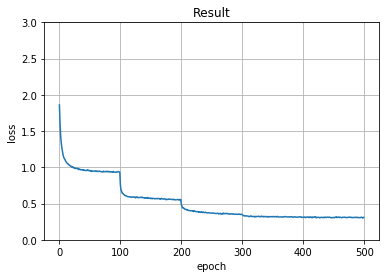

Checking accuracy on validation set
Got 884 / 1000 correct (88.40)


In [16]:
# Train your model here, and make sure the output of this cell is the accuracy of your best model on the 
# train, val, and test sets. Here's some code to get you started. The output of this cell should be the training
# and validation accuracy on your best model (measured by validation accuracy).

model_base = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
                    nn.BatchNorm2d(32, momentum=0.999), nn.LeakyReLU(inplace=True),
                    nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1, bias=False),
                    nn.BatchNorm2d(32, momentum=0.999), nn.LeakyReLU(inplace=True),
                    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
                    nn.BatchNorm2d(64, momentum=0.999), nn.LeakyReLU(inplace=True),
                    nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=False),
                    nn.BatchNorm2d(64, momentum=0.999), nn.LeakyReLU(inplace=True),
                    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
                    nn.BatchNorm2d(128, momentum=0.999), nn.LeakyReLU(inplace=True),
                    nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=False),
                    nn.BatchNorm2d(128, momentum=0.999), nn.LeakyReLU(inplace=True),
                    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
                    nn.BatchNorm2d(256, momentum=0.999), nn.LeakyReLU(inplace=True),
                    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                    nn.BatchNorm2d(256, momentum=0.999), nn.LeakyReLU(inplace=True),
                    nn.Conv2d(256, 10, kernel_size=1, stride=1, padding=0),
                    nn.AvgPool2d(4, stride=4),
                    Flatten(),
            )
model = model_base.type(gpu_dtype)
loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
optimizer = optim.SGD(model_base.parameters(), lr = 0.1, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

train(model, loss_fn, optimizer, num_epochs=500, scheduler=scheduler, plot_losses=True)
check_accuracy(model, loader_val)

### Describe what you did 

In the cell below you should write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

- A fully convolutional network with 9 conv layers and no fc layers.
- The structure of each conv layer is conv-bn-act.
- Only using 1x1 and 3x3 size of convolution kernels to reduce size of parameters.
- Using stride 2 convolution instead of max pooling.
- Using leaky relu as activation function.
- Using L2 weight decay regularization.
- Using data augmentation including left and right flipping and random croping to avoid overfitting.
- Using SGD with momentum to optimize the network.
- Decaying the learning rate to 1/10, when every time the loss function is slow and concussion, 
- The final accuracy on test sets is 87.8%.

## Test set -- run this only once

Now that we've gotten a result we're happy with, we test our final model on the test set (which you should store in best_model).  This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [17]:
best_model = model
check_accuracy(best_model, loader_test)

Checking accuracy on test set
Got 8774 / 10000 correct (87.74)


## Going further with PyTorch

The next assignment will make heavy use of PyTorch. You might also find it useful for your projects. 

Here's a nice tutorial by Justin Johnson that shows off some of PyTorch's features, like dynamic graphs and custom NN modules: http://pytorch.org/tutorials/beginner/pytorch_with_examples.html

If you're interested in reinforcement learning for your final project, this is a good (more advanced) DQN tutorial in PyTorch: http://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html